Electrocardiogram (ECG) labeling for the PYNQ board
<br><br>
In general, This notebook gives an example of how to configure the FPGA of the SoC from the PYNQ board with a neural network from this repo. It shows how to configure the neural network weights and inputs and how to load the output with the PYNQ framework methodology.
<br><br>
In particular, the neural network has been pre-trained for the [MIT-BIH Arrhythmia Database](https://www.physionet.org/content/mitdb/1.0.0/), but it may be trained for any other (Just by loading, retraining and exporting the weights to C headers from saved model arrythmia_kerasl_model.h5).
<br><br>
This neural network example is a classifier that has been [generated and trained](https://github.com/srivera1/TensorFlow_HLS_survivors/blob/master/arrythmia/clasificador_arritmia_version_aumentada_v0.ipynb) in Keras. After that, the network parameters and the intermediate calculations (to a given input) for each layer are exported as C header files. Finally, the neural network is imported to a Vivado project and synthesized.
<br><br>
The configuration of the PYNQ board is not vanilla: to run this notebook, some extra python libraries are needed (sklearn and wfdb).
<br><br>

In [1]:
import os
from shutil import copy2
import matplotlib.pyplot as plt

In [2]:
overlay_location2 = "/home/xilinx/pynq/overlays/arrythmia"

try:
    os.mkdir(overlay_location2)
except:
    pass

In [3]:
copy2("/home/xilinx/jupyter_notebooks/arrythmia/arrythmia.tcl",
         overlay_location2)
copy2("/home/xilinx/jupyter_notebooks/arrythmia/arrythmia.bit",
         overlay_location2)

'/home/xilinx/pynq/overlays/arrythmia/arrythmia.bit'

In [4]:
from pynq import Overlay
from pynq import MMIO
import numpy as np

# FPGA bitstream loading
bit_file = "arrythmia.bit"
ol = Overlay(bit_file)

# The control port of neural 
# network IP is located at 0x40000000
# The BRAM is located at 0x80000000
myNN   = MMIO(0x40000000,0x10000)
myBRAM = MMIO(0x90000000,0x10000)

In [5]:
import subprocess  

# user-space app for NN configuration
basename = "nn_user_space_app";  
execname = basename;  
srcname = basename + ".c";  

# user-space app compilation and execution
cmd = ["sh", "comp.sh"];  
p = subprocess.Popen(cmd);  
p.wait();   

In [6]:
def write_float(offset, data_as_float):
    '''
        Write a 4-byte float
    '''
    c=np.array([data_as_float], dtype=np.float32)
    myBRAM.write(offset, c.tobytes())

def read_float(offset, length):
    '''
        Read a 4-byte float
    '''
    float_list = []
    for i in range(length):
        data_4bytes = np.array([myBRAM.read(offset+i*4)], dtype=np.uint32)
        data_as_float = data_4bytes.view(dtype=np.float32)[0]
        float_list.append(data_as_float)
    return float_list

def nn_write_input(X):
    '''
        Write a 4-byte float array
    '''
    for i in range(2000):
        write_float(i*4, X[i])

def nn_execution():
    '''
        Neural network execution
    '''
    myNN.write(0,1)
    while myNN.read(0)==1: # wait 'till finish
        pass
    
def nn_configuration():
    '''
        FPGA configuration by user space
        app execution
        
        The generated file will execute one
        time the IP after the weights and
        sample Input are loaded to the FPGA
    '''
    subprocess.call(["./"+execname]); 

def nn_load_input():
    '''
        Read a 4-byte float array
    '''
    return read_float(0, 2000)

def nn_load_batch_normalization_78():
    '''
        This particular NN has been configurated to 
    '''
    return read_float(51504, int(172/4))

def nn_load_output():
    '''
        This particular NN has been configurated to output 
        the values for its 2 lastest layers: "Dense_78" 
        and "Batch_normalization_78". The result of the 
        layer "Batch_normalization_78" matches the values 
        of the file "./include/batch_normalization_78.h" 
        if the neural network is configurated with the 
        input and weighs from the "./include" folder. 

        The neural network is a classifier, so the final 
        result is the index of the neuron with larger 
        output. Due to this reason, the operation softmax 
        has not been implemented in hardware and the 
        results from "Dense_78" don't match the file 
        "./include/Dense_78.h".
    '''
    return read_float(52364, 23)

def nn_predict(X):
    '''
        FPGA predictions
        Classification problem, the result is the 
        index of the maximum value from last layer
    '''    
    nn_write_input(X)
    nn_execution()
    result = nn_load_output()
    
    return ( np.where(np.max( result ) == result))[0][0]

In [7]:
# Last layer from the unconfigured neural network

print(nn_load_output())

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [8]:
# Saved weight and input load to FPGA
# and 1-time execution to get results

nn_configuration()

In [9]:
# Last layer from the configured neural network

last_layer_result = nn_load_output()
print(last_layer_result)

[-1.1961398, -8.0660124, 5.1190662, -8.0330219, 3.8135214, 0.49204659, 0.71962458, -1.24845, -3.8227253, 9.1042738, -4.9311366, 6.9958115, -3.1001148, -3.6703558, -0.95308441, -3.962534, -0.13134891, -3.2412395, -5.5653892, 7.079741, 0.88582951, -0.39248696, 4.1531501]


In [10]:
# The classifier's result is the last layer 
# maximum's value neuron index.

result = np.argmax(last_layer_result)
print(result)

9


In [11]:
# FPGA calculated output from batch_normalization_78

print(nn_load_batch_normalization_78())

[-0.5700503, -0.1490375, 0.30698761, 1.3440915, -0.50283092, -0.91425157, 2.356662, -0.73145825, 0.41616127, -0.42376259, -0.50384688, 2.3527398, -0.81998426, 3.7678132, 1.520223, 1.8946608, 1.9175001, -0.19760808, -0.60109788, 2.5441129, -0.39565995, -0.016679637, 0.098684557, 1.2537465, 0.9493134, 2.8896527, 2.5902996, -0.88303304, 0.36698648, 3.6500673, -0.71167332, -1.0023994, 0.4054997, -0.19412071, -0.62493312, 6.4456682, 0.58504254, -0.35806003, -0.68981361, -0.70256084, 1.294251, -0.18596236, 0.09443792]


In [12]:
# Keras calculated output from batch_normalization_78

!cat "./include/batch_normalization_78.h"

// include/batch_normalization_78.h
// sergio rivera 
// 2020/03/13 22:37:16 

const float batch_normalization_78_p[1][43]=
{
	{-0.57005095,-0.14903745,0.3069871,1.3440918,-0.5028312,-0.9142515,2.3566623,-0.73145825,0.41616106,-0.42376179,-0.5038469,2.35274,-0.8199836,3.767813,1.5202227,1.8946619,1.9174994,-0.19760808,-0.6010978,2.5441134,-0.3956599,-0.016679406,0.09868458,1.2537475,0.9493156,2.8896523,2.5903006,-0.88303304,0.36698568,3.6500678,-0.711674,-1.0023994,0.40549886,-0.19412065,-0.6249331,6.4456735,0.5850427,-0.35806006,-0.6898137,-0.70256084,1.2942524,-0.18596229,0.09443712	}
};

/usr/lib/python3/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


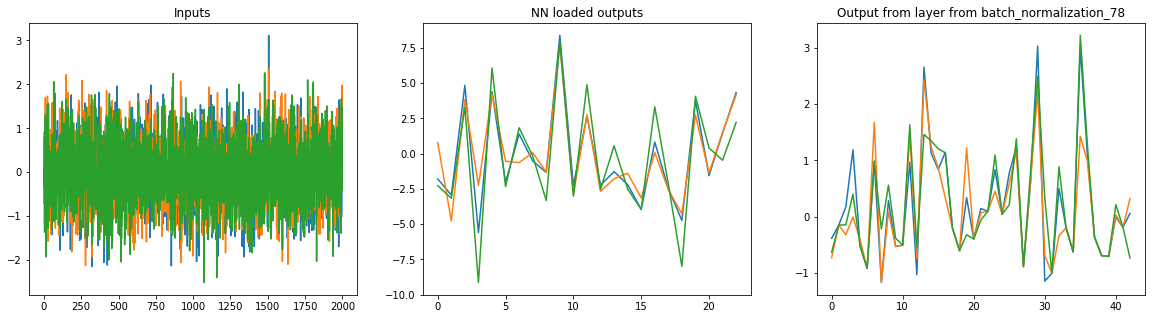

In [13]:
# Test the NN with similar random inputs

X_tmp = nn_load_input()
X=np.zeros(len(X_tmp))

plt.figure(figsize=(20,5))

for i in range(3):
    
    X = np.array(X_tmp) + np.random.normal(0,0.5,len(X))
    
    nn_write_input(X)

    nn_execution()
    
    plt.subplot(1,3,1)
    plt.title("Inputs", fontdict=None, loc='center')
    plt.plot(X)
    plt.subplot(1,3,2)
    plt.title("NN loaded outputs", fontdict=None, loc='center')
    plt.plot(nn_load_output())
    plt.subplot(1,3,3)
    plt.title("Output from layer from batch_normalization_78", fontdict=None, loc='center')
    plt.plot(nn_load_batch_normalization_78())
    
plt.show()

In [14]:
# Download the database to the PYNQ
# to test the neural network execution with real data.
#
# Download files from physionet.org (this way takes a while)
#
# cmd = ["wget", "-r", "-N", "-c", "-np",
#        "https://physionet.org/files/mitdb/1.0.0/"]
#
# p = subprocess.Popen(cmd);  
# p.wait();   

In [15]:
data_path = "physionet.org/files/mitdb/1.0.0/"

In [16]:
pts = ["100", "101", "102", "103", "104", "105", "106", "107", "108", "109", "111", "112", "113", "114", "115", "116", "117", "118", "119", "121", "122", "123", "124", "200", "201", "202", "203", "205", "207", "208", "209", "210", "212", "213", "214", "215", "217", "219", "220", "221", "222", "223", "228", "230", "231", "232", "233", "234"]

In [17]:
import pandas as pd
df=pd.DataFrame()

import numpy as np
import math 
from os import listdir
import wfdb
from tempfile import TemporaryFile
from sklearn import metrics
from sklearn.model_selection import train_test_split

for pt in pts:
    file = data_path +  pt
    annotation = wfdb.rdann(file, 'atr')
    sym = annotation.symbol
    
    values, counts = np.unique(sym, return_counts=True)
    df_sub = pd.DataFrame({'sym': values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub],axis = 0)

In [18]:
annotations_histogram = df.groupby('sym').val.sum().sort_values(ascending = False)
print(annotations_histogram)

sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int32


In [19]:
def trad_symbol(x):
    symbol = ["[", "Start of ventricular flutter/fibrillation",
    "!", "Ventricular flutter wave",
    "]", "End of ventricular flutter/fibrillation",
    "x", "Non-conducted P-wave (blocked APC)",
    "(", "Waveform onset",
    ")", "Waveform end",
    "p", "Peak of P-wave",
    "t", "Peak of T-wave",
    "u", "Peak of U-wave",
    "`", "PQ junction",
    "'", "J-point",
    "^", "(Non-captured) pacemaker artifact",
    "|", "Isolated QRS-like artifact [1]",
    "~", "Change in signal quality [1]",
    "+", "Rhythm change [2]",
    "s", "ST segment change [2]",
    "T", "T-wave change [2]",
    "*", "Systole",
    "D", "Diastole",
    "=", "Measurement annotation [2]",
    '"', "Comment annotation [2]",
    "@", "Link to external data [3]",
    "N", "Normal beat (displayed as · by the PhysioBank ATM, LightWAVE, pschart, and psfd)",
    "L", "Left bundle branch block beat",
    "R", "Right bundle branch block beat",
    "B", "Bundle branch block beat (unspecified)",
    "A", "Atrial premature beat",
    "a", "Aberrated atrial premature beat",
    "J", "Nodal (junctional) premature beat",
    "S", "Supraventricular premature or ectopic beat (atrial or nodal)",
    "V", "Premature ventricular contraction",
    "r", "R-on-T premature ventricular contraction",
    "F", "Fusion of ventricular and normal beat",
    "e", "Atrial escape beat",
    "j", "Nodal (junctional) escape beat",
    "n", "Supraventricular escape beat (atrial or nodal)",
    "E", "Ventricular escape beat",
    "/", "Paced beat",
    "f", "Fusion of paced and normal beat",
    "Q", "Unclassifiable beat",
    "?", "Beat not classified during learning"]
    for i in range(int(len(symbol)/2)):
        if x==symbol[i*2]:
            return symbol[i*2 + 1]
    return "Symbol not found"

In [20]:
# Helper functions

def load_ecg(file):
    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, 'atr')
    
    p_signal = record.p_signal
    
    assert record.fs == 360, 'sample freq is not 360'
    
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample

def get_index(array, val):
    index = -1
    for k in array:
        index += 1
        if k==val:
            return index
    return index   

In [21]:
# curves selection
# The whole datasheet doesn't fit 
# in the PYNQ board: It is only 
# selected a few curves from each category.

N_curves_per_category = 3
tt=annotations_histogram.keys()
annotation_values = tt.get_values()
amount_of_curves = (np.zeros(len(tt.get_values())) + N_curves_per_category).astype(int)

# a few more normal beats
amount_of_curves[0] = N_curves_per_category * 10

In [22]:

X=[]
Y=[]
def load_data():
    halfRange=1000
    save = 0
    if save == 1:
        f = open('ecg_csvfile.csv','w')
    firstTime=1
    for pt in pts:
        file = data_path + pt
            
        p_signal, atr_sym, atr_sample = load_ecg(file)
        showPlot=0
        if showPlot == 1:
            plt.plot(p_signal[1:5000,0])
            plt.plot(p_signal[1:5000,1])
            plt.show()
            print(np.array(p_signal).shape)
            print(np.array(p_signal)[:,:])
        x = np.arange(len(p_signal))
        
        
        for a,b in zip(atr_sym, atr_sample):
            line=[]
            if b-halfRange>0 & b+halfRange<len(p_signal):
                u=p_signal[b-halfRange:b+halfRange,0]
                break
        print(pt)
        if firstTime==1:
            tmp=u.shape[0]
            
        N_normal_curves = 0
        N_max_normal_curves = 10
        
        for a,b in zip(atr_sym, atr_sample):
            line=[]
            if b-halfRange>0 & b+halfRange<len(p_signal):
                if save == 1:
                    [line.append(str(i)) for i in p_signal[b-halfRange:b+halfRange,0]]
                    line.append(str(ord(a)))
                    f.write(' '.join(line))
                    f.write('\n')
                else:
                    if p_signal[b-halfRange:b+halfRange,0].shape[0]==tmp:                        
                        if amount_of_curves[get_index(annotation_values, a)] > 0:
                            u=p_signal[b-halfRange:b+halfRange,0].reshape(u.shape[0],1)
                            X.append(u)
                            Y.append(ord(a))
                            amount_of_curves[get_index(annotation_values, a)] -= 1
                    
    if save == 1:
        f.close()
        return [], []
    else:
        X_full = np.array(X)
        Y_full = np.array(Y)
        print(X_full.shape, Y_full.shape)
        return X_full, Y_full

X_full, Y_full = load_data()
print(X_full.shape, Y_full.shape)

100
101
102
103
104
105
106
107
108
109
111
112
113
114
115
116
117
118
119
121
122
123
124
200
201
202
203
205
207
208
209
210
212
213
214
215
217
219
220
221
222
223
228
230
231
232
233
234
(95, 2000, 1) (95,)
(95, 2000, 1) (95,)


In [23]:
num_sec = 3
fs = 360

X_all = X_full.reshape(X_full.shape[0],X_full.shape[1])
Y_all = []
values, counts = np.unique(Y_full, return_counts = True)
values_list=[]

for i in values:
    values_list.append(i)
    
for i in Y_full:
    Y_all.append(values_list.index(i))
    
Y_all = np.array(Y_all)

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X_all, Y_all, test_size=0.1, train_size=0.9, random_state=42)

values= values_list

del X_all, Y_all

In [25]:
dictionary = [chr(i) for i in values]

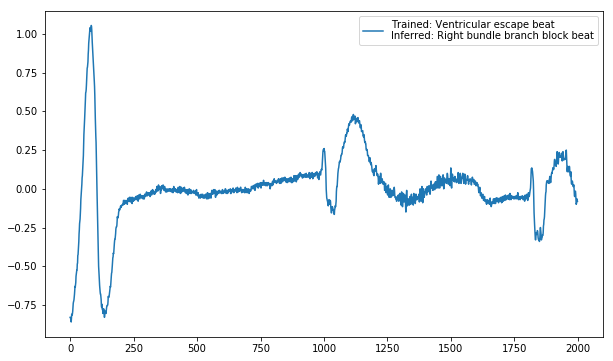

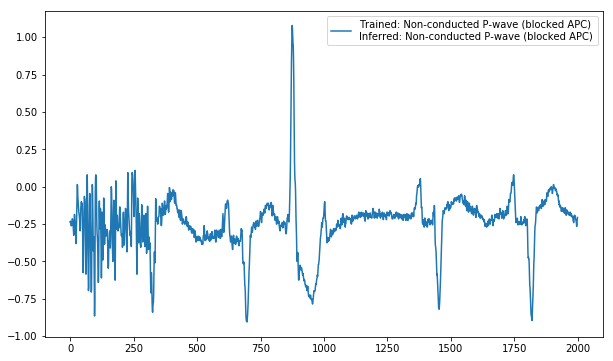

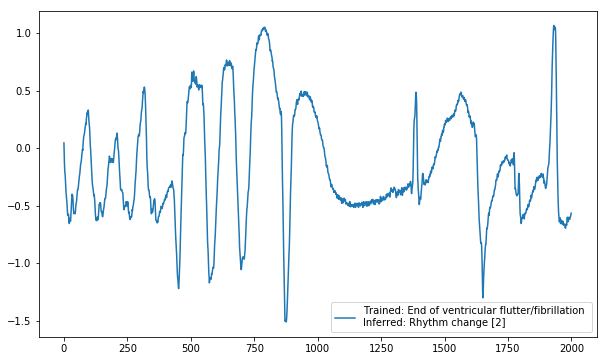

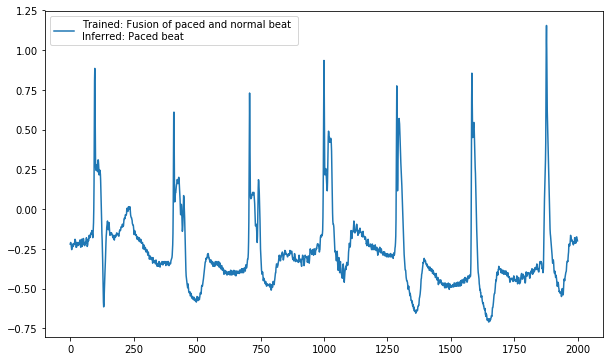

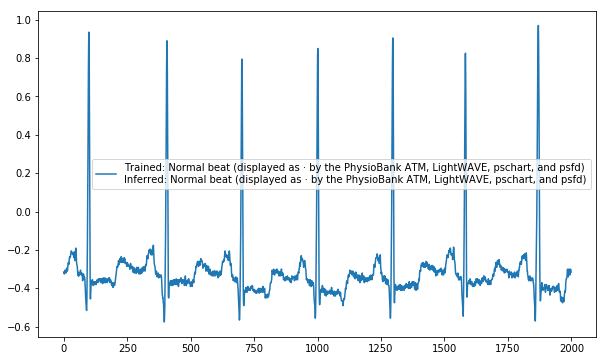

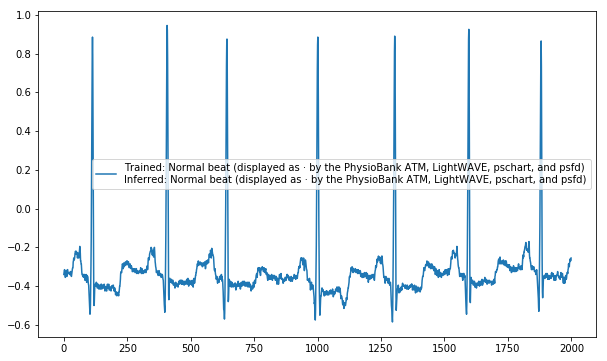

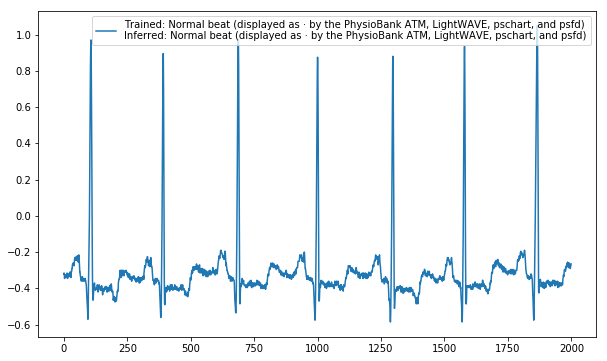

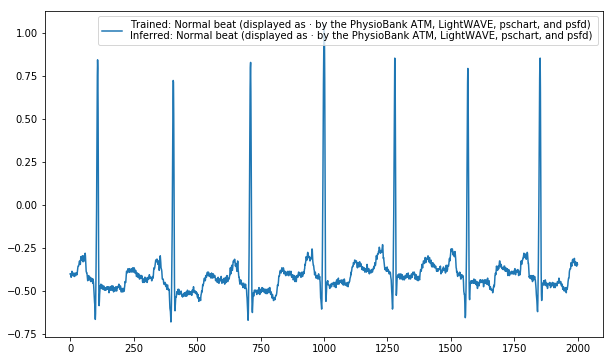

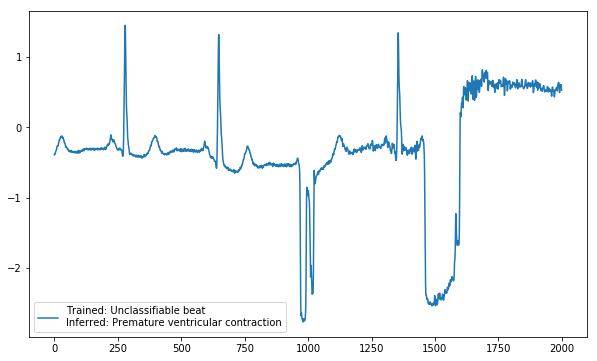

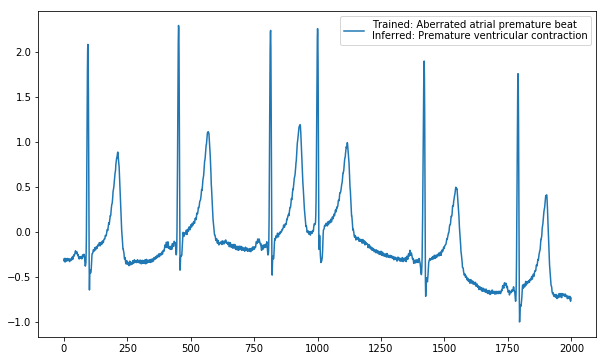

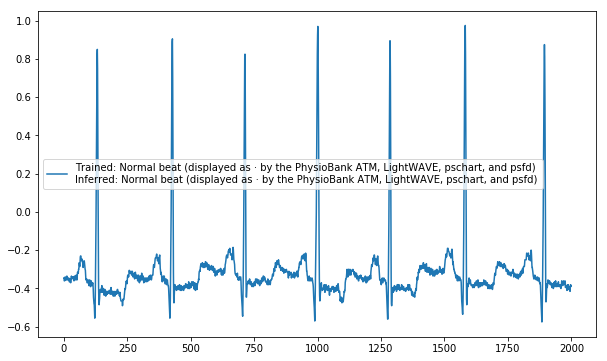

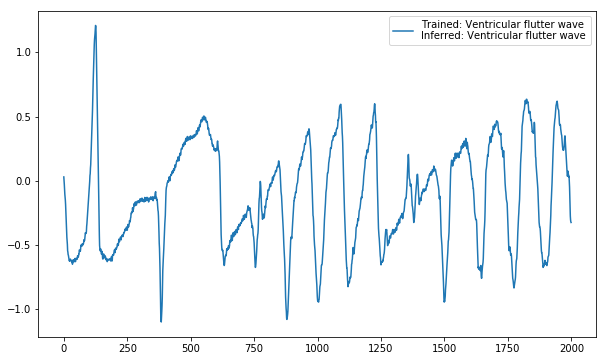

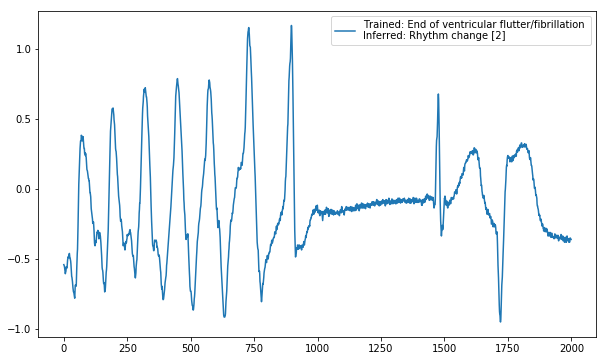

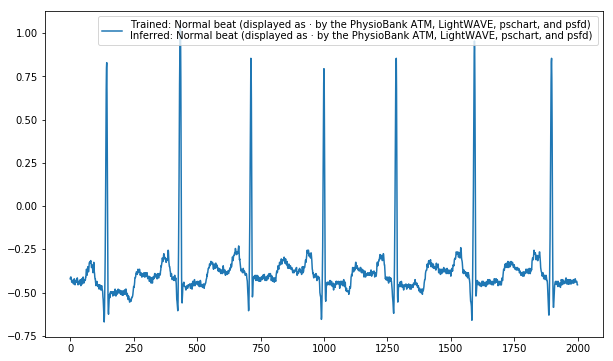

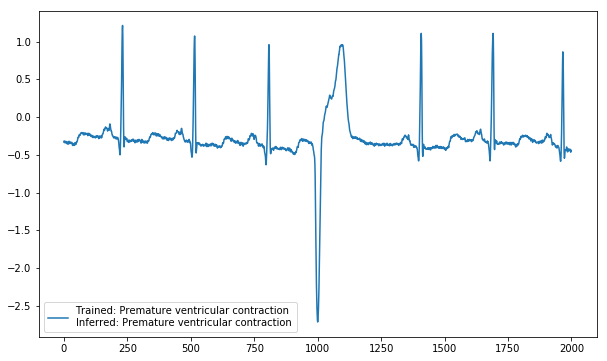

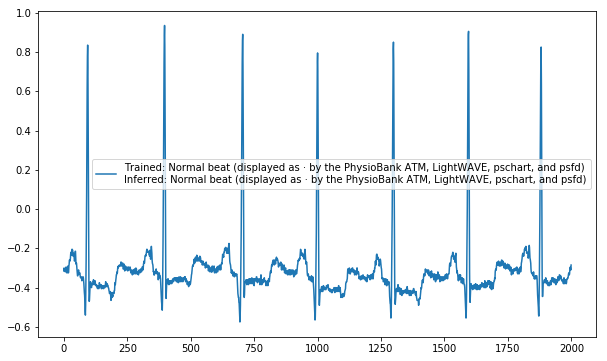

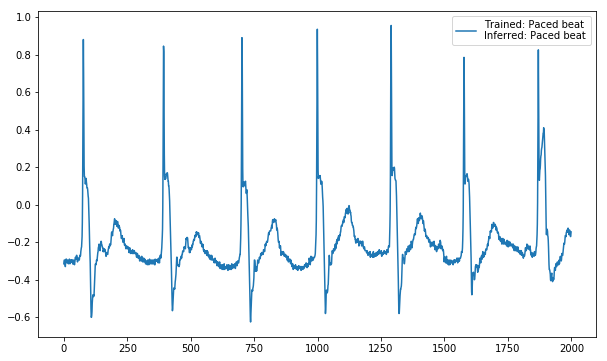

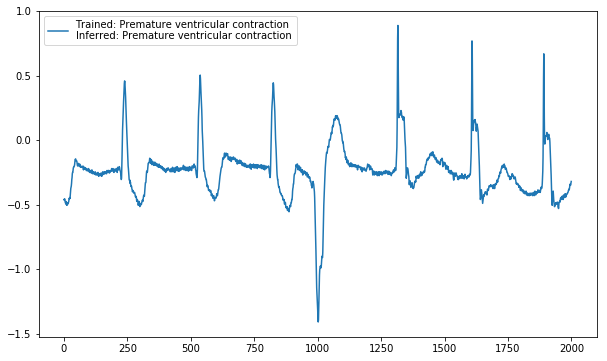

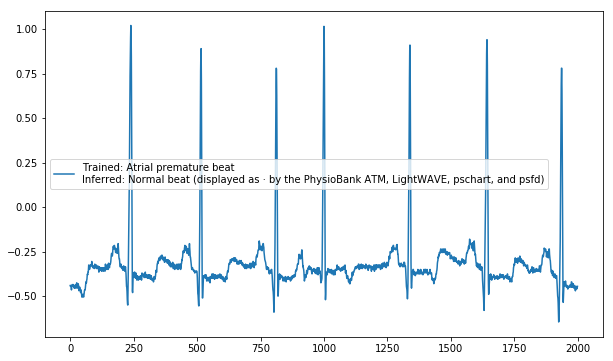

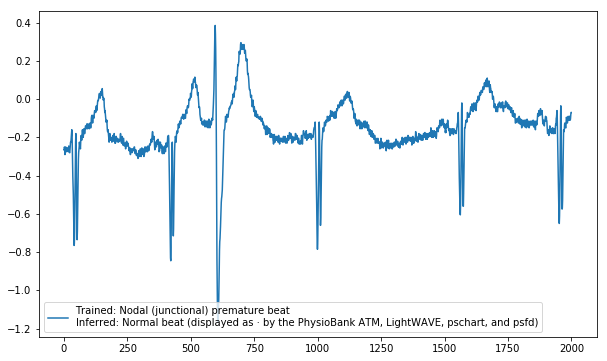

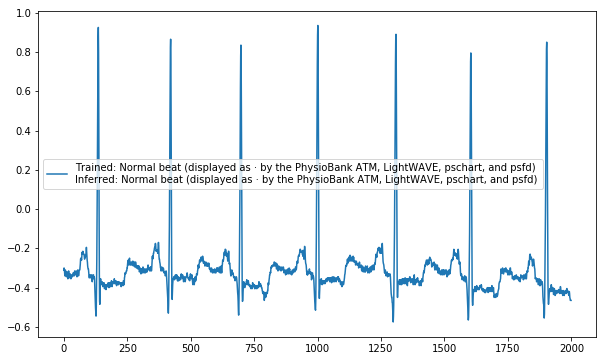

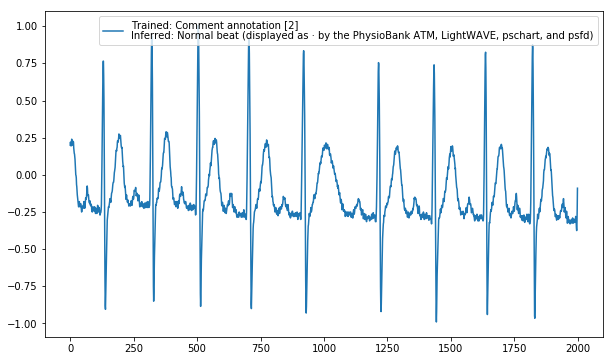

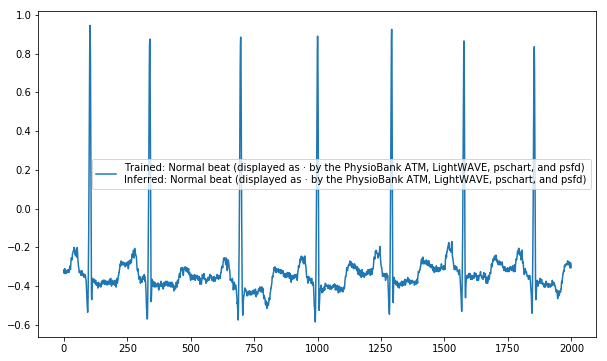

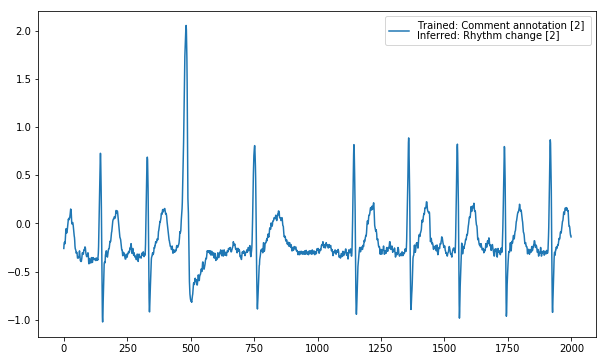

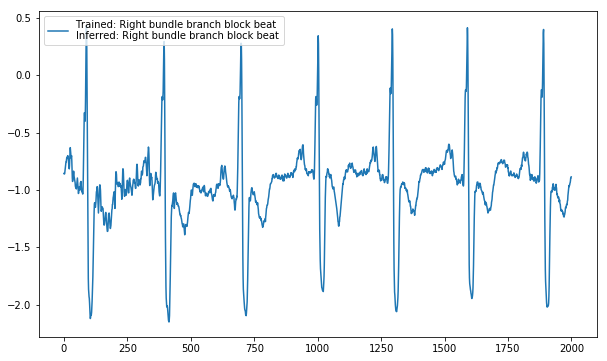

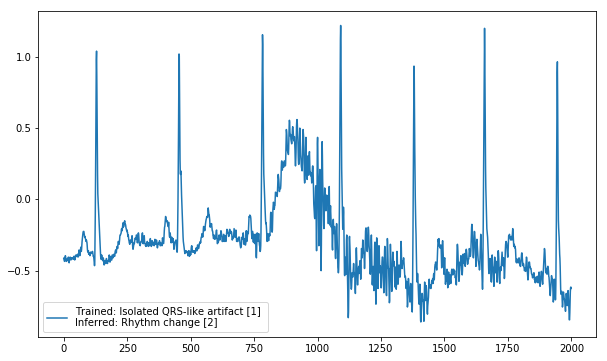

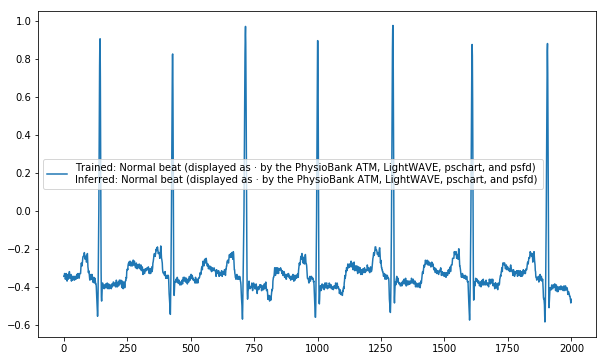

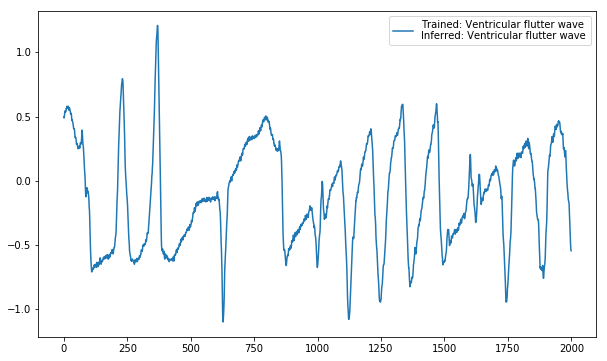

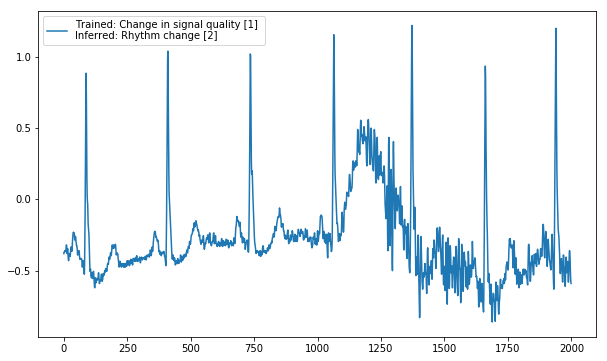

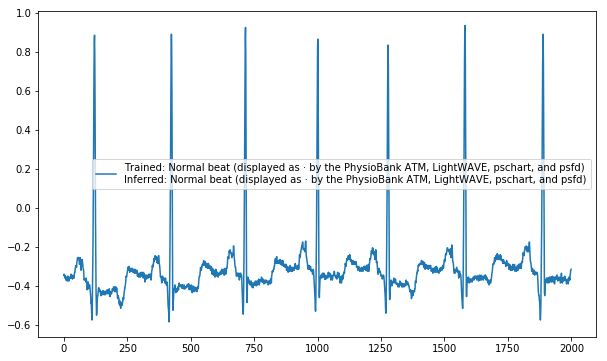

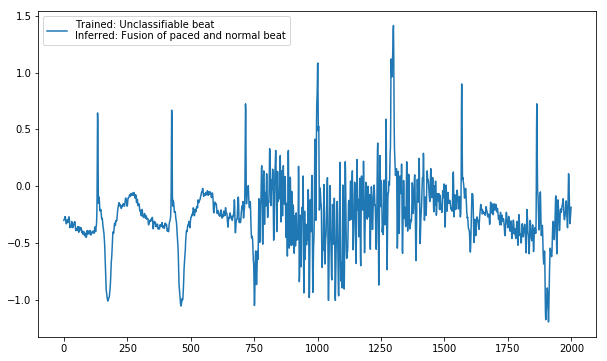

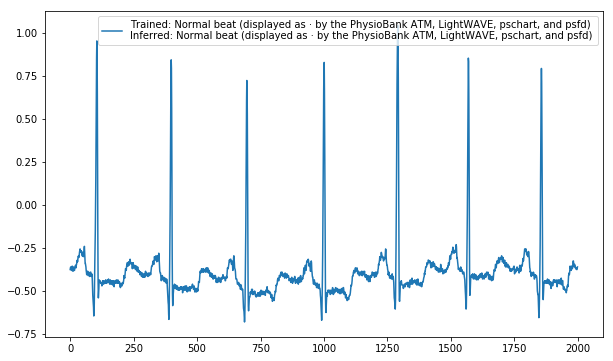

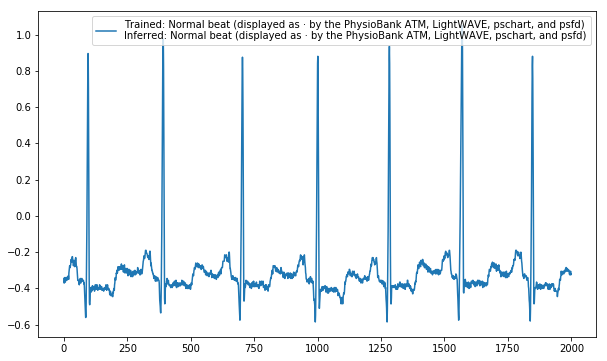

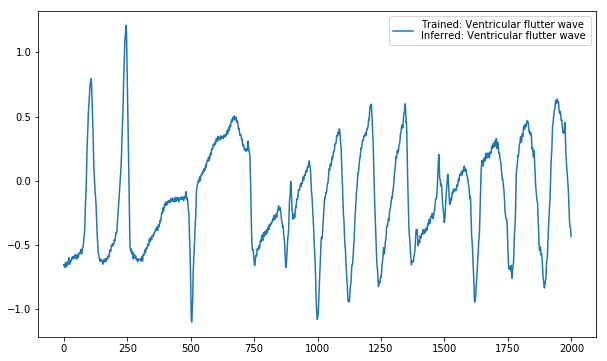

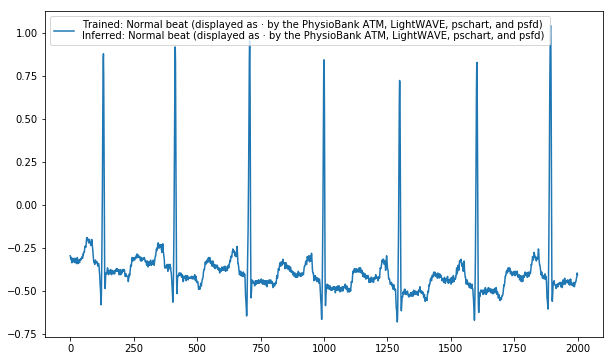

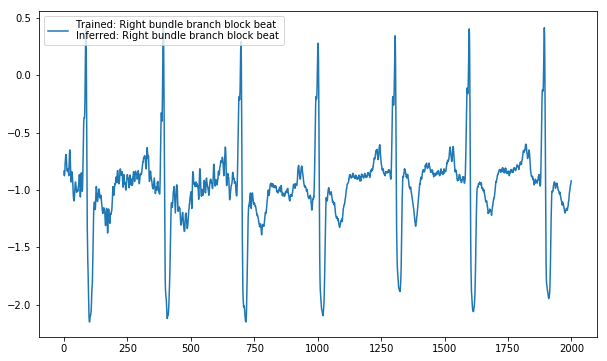

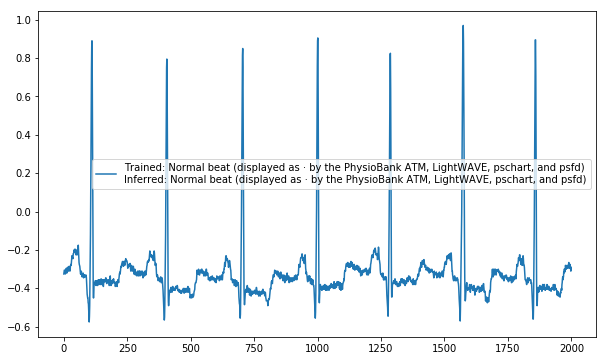

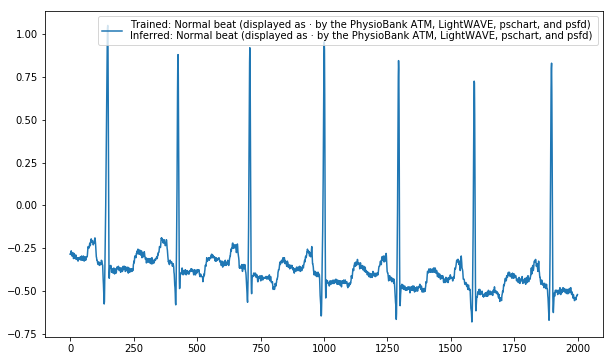

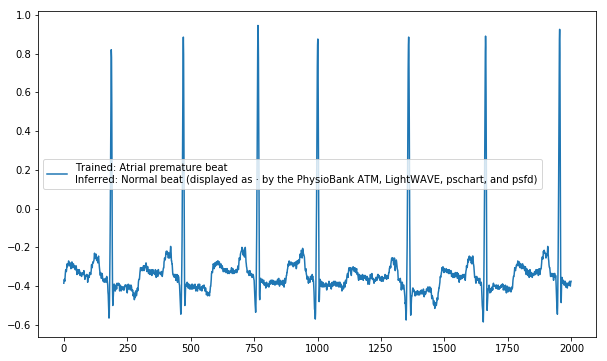

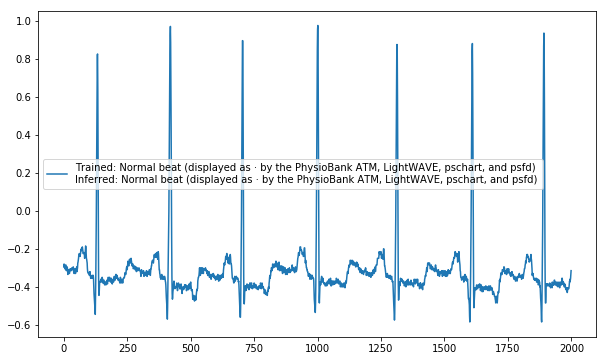

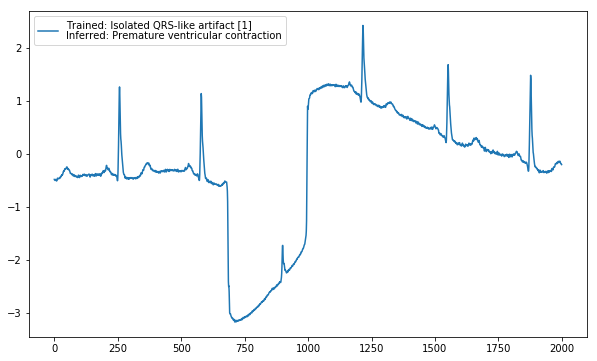

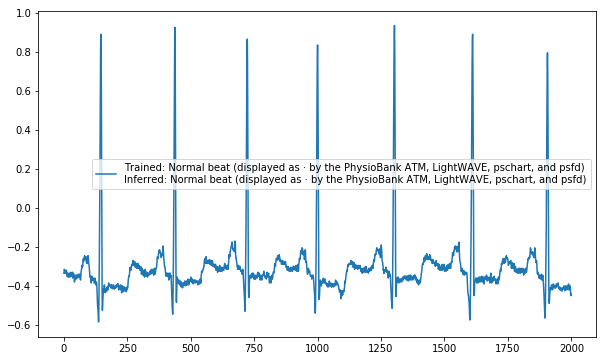

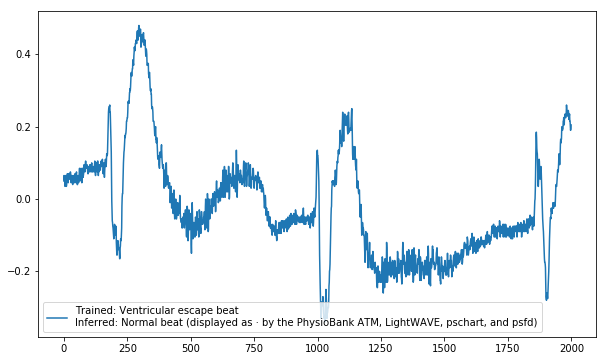

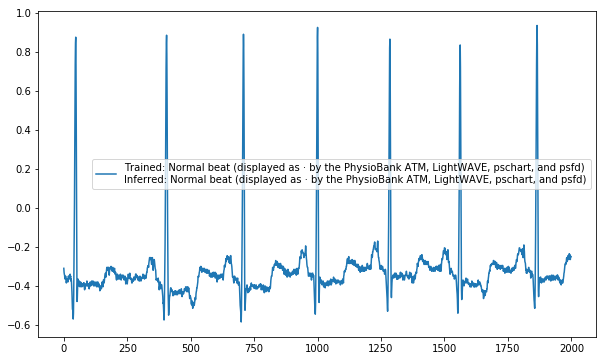

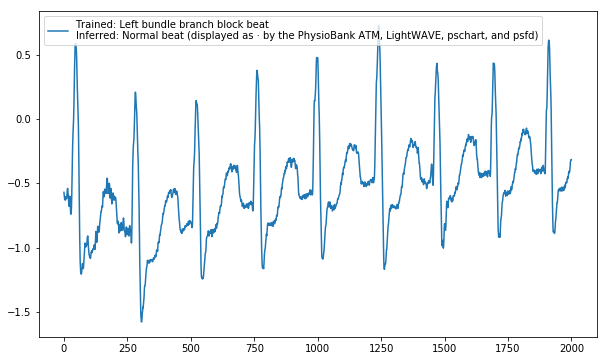

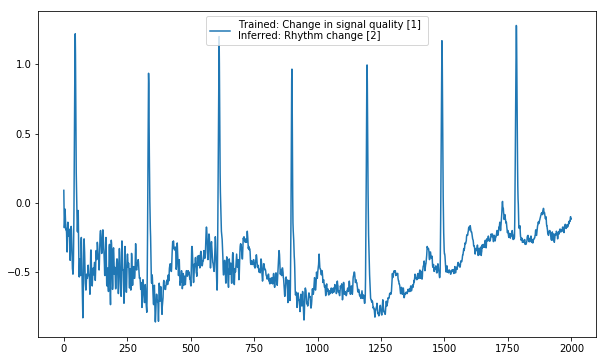

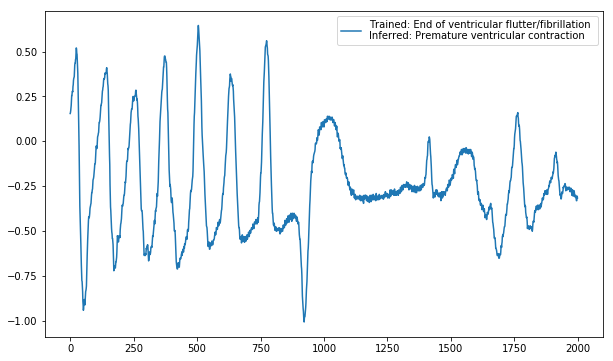

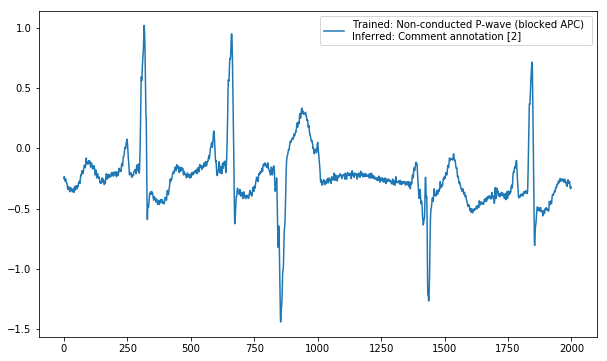

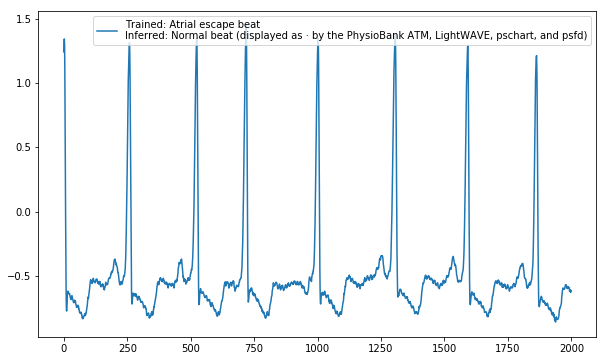

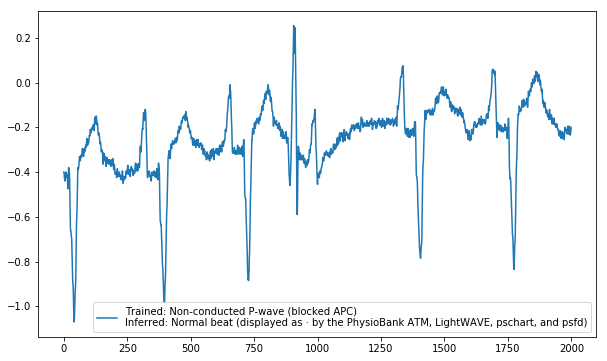

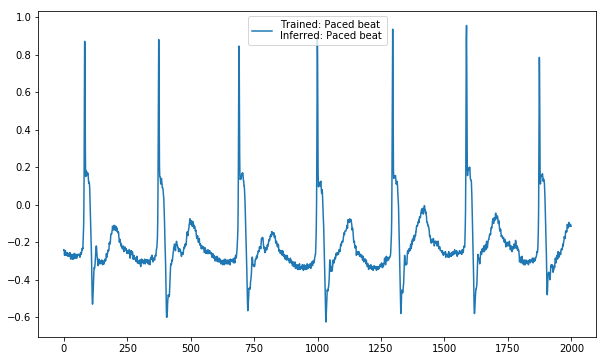

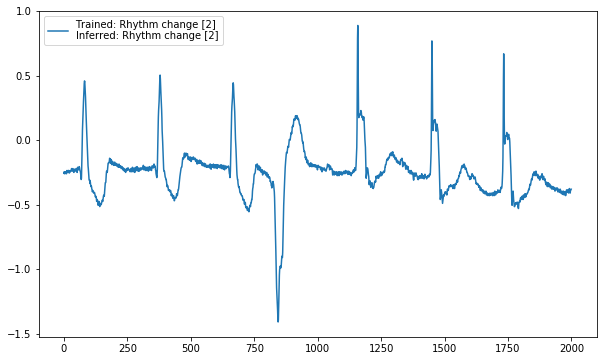

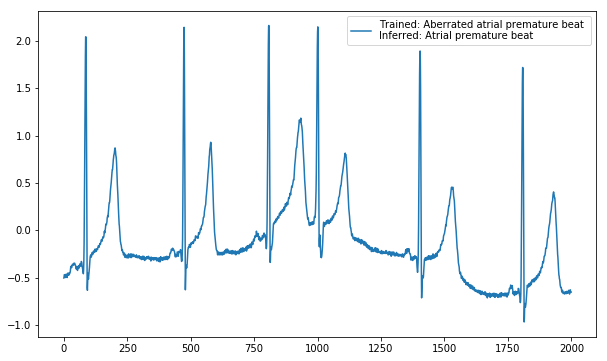

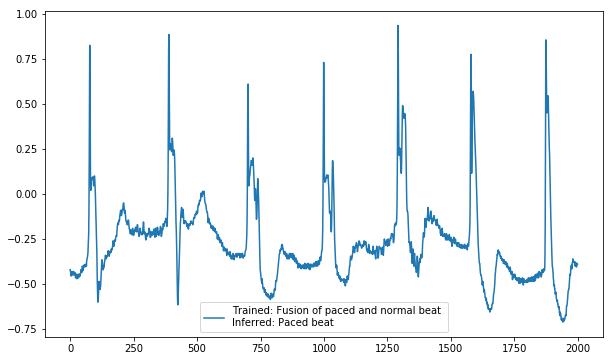

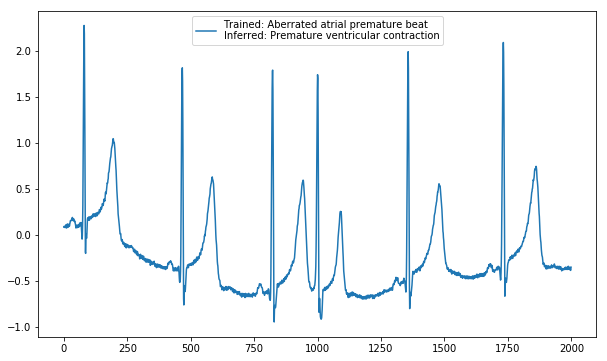

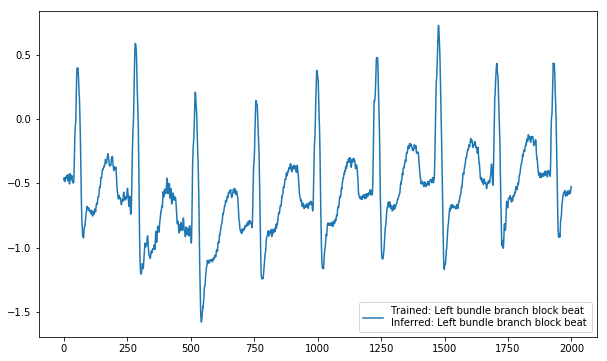

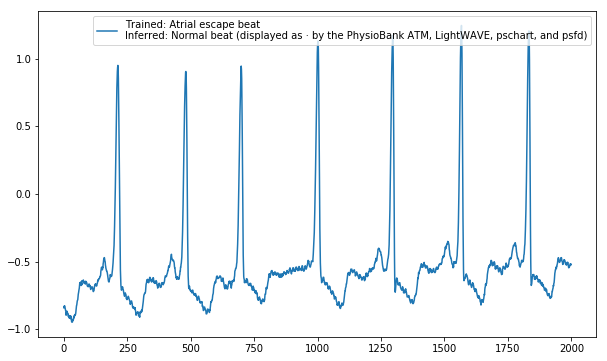

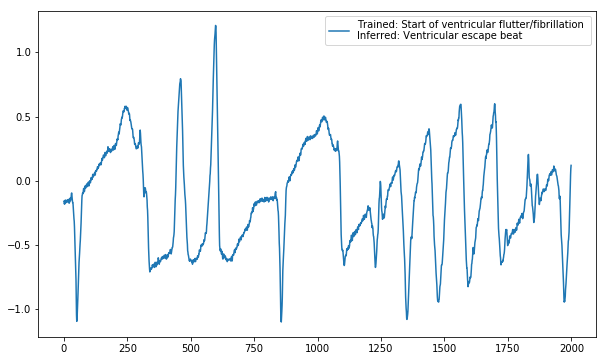

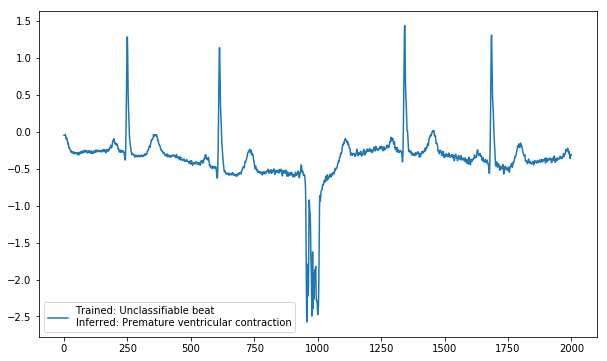

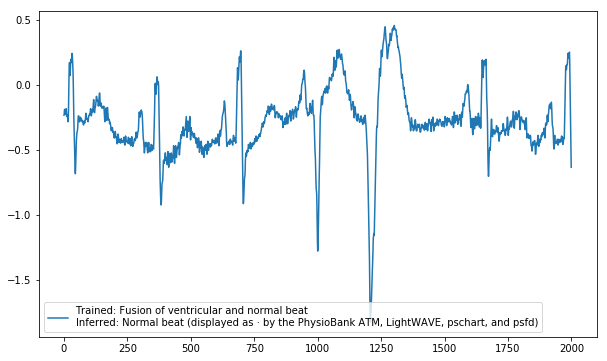

In [26]:
# Plotting FPGA predictions

y_train_preds_dense = []
y_valid_preds_dense = []

for i in range(len(X_train)):
    
    # make FPGA predictions:
    y_train_preds_dense.append(nn_predict(X_train[i].astype(float)))
    
y_train_preds_dense = np.array(y_train_preds_dense)

N_curves = np.min([len(X_train), 60]) 
for i in range(N_curves):
    label = "Trained: " + trad_symbol(dictionary[y_train[i]]) + " " + "\nInferred: " + trad_symbol(dictionary[y_train_preds_dense[i]])
    plt.figure(figsize = (10, 6))
    plt.plot(X_train[i])
    plt.legend([label])
    plt.show()

In [27]:
print("rms:                           ", np.sqrt(np.power(y_train_preds_dense-y_train,2).sum()/len(y_train_preds_dense)))
print("total number of beats:         ", y_train_preds_dense.shape[0])
print("total number of unknown beats: ", (y_train_preds_dense!=y_train).astype(int).sum())
print("% error:                       ", (y_train_preds_dense!=y_train).astype(int).sum()/y_train_preds_dense.shape[0]*100)

rms:                            6.82124708281
total number of beats:          85
total number of unknown beats:  43
% error:                        50.5882352941


 The trained error for the current loaded weights is about 3% in validation for the hole datasheet.
 Howerver, considering just the selected curves, the error is 50%

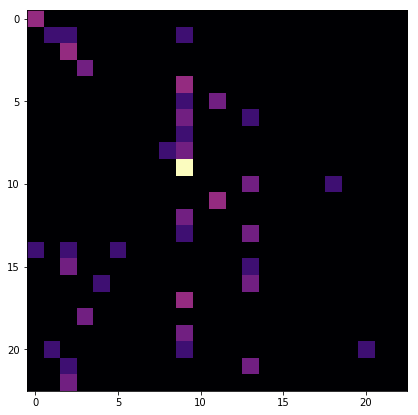

In [28]:
# confusion matrix
plt.figure(figsize = (15,7))

cm=metrics.confusion_matrix(y_train, y_train_preds_dense)
plt.subplot(121)
plt.imshow(np.log(cm+1), cmap='magma')

Acknowledgments:

    1) https://towardsdatascience.com/detecting-heart-arrhythmias-with-deep-learning-in-keras-with-dense-cnn-and-lstm-add337d9e41f

    2) physionet.org
